In [1]:
import pandas as pd
from pathlib import Path
from src.mevpt import *
from src.scaling_helper import *
from src.mplstyle import set as set_mplstyle
from itertools import cycle
from IPython.utils import io
from scipy.stats import gaussian_kde
set_mplstyle("Fira Sans")

VAR = "DPT"
DATA_DOC_PATH = Path("./data/dataset_docs/")
OUTPUT_PATH = Path("./output/figures/")
OE_DIR = {"TMEAN": Path("./data/OE_tmean_era5/"), "DPT": Path("./data/OE_dpt_era5/")}
STATION_LIST = {"TMEAN": pd.read_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv"), "DPT": pd.read_csv(DATA_DOC_PATH / "p_dpt_stations_ge30y_70pct_good.csv")}

In [4]:
regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
var = VAR
for d in ["1h", "24h"]:
    print(f"------ {d} ------")
    for i, region in enumerate(regions):
        stations = STATION_LIST[var][STATION_LIST[var]["KG"] == region]
        stn = stations.sort_values(by=["Num_Year_Overlap_" + d], ascending=False).iloc[0]
        print(f'{region}: {stn["StnID"]}')

------ 1h ------
BSk: USC00415410
BWk: USC00299686
Cfa: USW00012911
Csb: USC00357127
Dfa: USW00013802
Dfb: USC00244143
------ 24h ------
BSk: USC00415410
BWk: USC00299686
Cfa: USW00012911
Csb: USC00357127
Dfa: USW00013802
Dfb: USC00244143


In [12]:
def cw_scaling_analysis(stn_id, d, var, data_dir):
    df = load_data(stn_id, d, data_dir=data_dir)
    prcp, exg = df["PRCP"].values, df[var].values

    cw_scaling = scaling_analysis(prcp, exg, var, ci=True, ntimes=1000, n_bins=12)

    threshold = np.percentile(prcp, 10)
    c_reg = linregress(cw_scaling[var+"_med"], cw_scaling["c"])
    w_reg = linregress(cw_scaling[var+"_med"], np.log10(cw_scaling["w"]))

    initial_guess = [np.exp(c_reg.intercept), c_reg.slope, np.exp(w_reg.intercept) , w_reg.slope]

    cw_reg = exponential_reg_ML(prcp-threshold, exg, initial_guess=initial_guess)
    return cw_scaling, cw_reg


def plot_inset_station(regions, main_ax, coords, position):
    proj_5070 = ccrs.AlbersEqualArea(
        central_longitude=-96,
        central_latitude=23,
        false_easting=0.0,
        false_northing=0.0,
        standard_parallels=(29.5, 45.5),
    )
    extent = [-125, -66.75, 24.5, 49.5]
    values, colors = get_region_color(regions)

    with rasterio.open(KG_RASTER_PATH) as src:
        data = src.read(1)
        combined_mask = np.zeros_like(data, dtype=bool)
        for value in values:
            combined_mask |= data == value
        data_masked = np.ma.masked_where(~combined_mask, data)

        ax = main_ax.inset_axes(
            position, projection=proj_5070
        )  # left, bottom, width, height
        ax.set_extent(extent, crs=ccrs.PlateCarree())

        sorted_pairs = sorted(zip(values, colors))
        sorted_values, sorted_colors = zip(*sorted_pairs)
        cmap = ListedColormap(sorted_colors)
        boundaries = list(sorted_values) + [
            max(sorted_values) + 1
        ]  # Add upper boundary
        norm = BoundaryNorm(boundaries, len(sorted_colors))

        im = ax.imshow(
            data_masked,
            cmap=cmap,
            norm=norm,
            extent=[
                src.bounds.left,
                src.bounds.right,
                src.bounds.bottom,
                src.bounds.top,
            ],
            transform=ccrs.PlateCarree(),
            interpolation="nearest",  # Prevents pixel averaging
            resample=False,
        )

        bnd = gpd.read_file("data/shp/CONUS_boundary.shp")
        ax.add_geometries(
            bnd.geometry,
            crs=ccrs.PlateCarree(),
            color="none",
            edgecolor="k",
            linewidth=0.3,
            zorder=2,
        )

        ax.scatter(
                x=coords["Lon"],
                y=coords["Lat"],
                transform=ccrs.PlateCarree(),
                edgecolors="k",
                color="red",
                s=10,
                zorder=10,
                linewidths=0.5,
            )
    return ax


def plot_scaling_stations(res_bin, res_reg, coords, var, d, savedir=None):
    ax_params = {
        "c": {
            "xlabel": "$T~[^{\circ} C]$" if var == "TMEAN" else "$\\text{DPT}~[^{\circ} C]$",
            "ylabel": "$log~c~[\\text{mm} \cdot \\text{hr}^{-1}]$",
        },
        "w": {"xlabel": "$T~[^{\circ} C]$" if var == "TMEAN" else "$\\text{DPT}~[^{\circ} C]$", "ylabel": "$w$"},
    }
    predict_param = {
        "c": lambda *args, **kwargs: np.log10(c_T(*args, **kwargs)),
        "w": w_T,
    }
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    for param in ["c", "w"]:
        fig, axs = plt.subplots(2, 3, figsize=(8, 4), constrained_layout=True)
        axs = axs.flatten()
        for i, region in enumerate(res_bin):
            cw_scaling = res_bin[region]
            cw_reg = res_reg[region]

            T_reg = np.linspace(
                cw_scaling[f"{var}_med"].min(), cw_scaling[f"{var}_med"].max(), 10
            )
            axs[i].plot(
                T_reg,
                predict_param[param](
                    T_reg, cw_reg[f"{param}0"], cw_reg[f"beta_{param}"]
                ),
                "r-",
                lw=3,
            )
            axs[i].plot(
                cw_scaling[f"{var}_med"],
                cw_scaling[param],
                "-o",
                c=COLORS[0],
                ms=5,
                mfc="none",
            )
            axs[i].fill_between(cw_scaling[f"{var}_med"],cw_scaling[f"{param}_up"], cw_scaling[f"{param}_low"],
                    alpha=0.3, color=COLORS[0], edgecolor="None")
            
            axs[i].set(
                xlabel=ax_params[param]["xlabel"] if i // 3 else None, ylabel=ax_params[param]["ylabel"] if not i % 3 else None,
                title=regions[i]
            )
            if param == "c":
                plot_inset_station([region], axs[i], coords[region], [0.05, 0.65, 0.35, 0.3])
                ylim = axs[i].get_ylim()
                xlim = axs[i].get_xlim()
                for c0 in np.linspace(ylim[0], ylim[1], 3):
                    T = np.linspace(xlim[0], xlim[1], 10)
                    y_line = c0 + np.log10(0.068 + 1) * (T - np.mean(T))
                    axs[i].plot(T, y_line, "--k", linewidth=0.2)
                axs[i].set_ylim((ylim[0], ylim[1] + 0.3*(ylim[1]-ylim[0])))
        if savedir:
            fig.savefig(savedir / f"si_{param}_scaling_{d}.pdf", dpi=300, format="pdf")
        plt.show()

def plot_qq(am, quant_MEV, ax):
    q_mean = quant_MEV["Q_mean"]
    q_low = quant_MEV["Q_lower"]
    q_up = quant_MEV["Q_upper"]

    ax.scatter(am, q_mean, s=9, ec="k", c= "None", marker='o', zorder=3)

    sort_idx = np.argsort(am)
    am_sorted = am[sort_idx]
    quant_sorted = q_mean[sort_idx]
    lower_sorted = q_low[sort_idx]
    upper_sorted = q_up[sort_idx]
    ax.fill_between(am_sorted, lower_sorted, upper_sorted, alpha=0.3, color='grey', label='95% CI', ec="None", zorder=2)

    min_val = min(np.min(am), np.min(q_mean))
    max_val = max(np.max(am), np.max(q_mean))
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', zorder=1)
    return ax


def plot_SR_analysis(stn, d, var, savedir=None):
    df = load_data(stn["StnID"], d, data_dir=OE_DIR[var])
    prcp, exg = df["PRCP"].values, df[var].values

    threshold = np.percentile(prcp, 10)
    cw_reg = exponential_reg_ML(prcp-threshold, exg)

    T_bins = np.arange(-40, 40, 0.5)
    T_freq, T_midbin = T_histogram(T_bins, exg, pmf=True, ax=None)

    N_event_p_y = df["PRCP"].resample("YE").count().mean()
    Trs = np.linspace(5,100,50)
    T_fixed = np.array([5, 15, 25])
    delta_T = np.arange(0, 4.1, 0.5)
    n_fixed = np.array([N_event_p_y*0.75, N_event_p_y, N_event_p_y*1.25])
    c_fixed = c_T(T_fixed, cw_reg["c0"], cw_reg["beta_c"])
    #w_fixed = w_T(T_fixed, cw_reg["w0"], cw_reg["beta_w"])
    w_fixed = np.array([0.8, 1, 1.2])

    def SR_vs_TR(c, w, n, cw_reg_, Trs):
        """
        Set c=None or w=None to make it function of T
        return the SR as array with size = len(Trs)
        """
        SR = np.zeros(len(Trs))
        for i, Tr in enumerate(Trs):
            cond_cdf = partial(wei_cond_cdf_varying, cw_reg=cw_reg_, c=c, w=w)
            F = 1 - 1 / Tr
            quant = np.array(
                [
                    mev_PT_icdf_robust(
                        F,
                        T_midbin + delta_T_i,
                        T_freq,
                        n,
                        cond_cdf,
                    )
                    + threshold
                    for delta_T_i in delta_T
                ]
            ).flatten()
            reg = linregress(delta_T, np.log(quant))
            SR[i] = (np.exp(reg.slope) - 1) * 100
        return SR

    with plt.rc_context({"figure.figsize": (7, 3)}):
        colors = cycle(np.flip(["#fdcc8a", "#fc8d59", "#d7301f"]))
        fig, axs = plt.subplots(1, 3)
        for n in np.flip(n_fixed):
            sr = SR_vs_TR(None, None, n, cw_reg, Trs)
            if n == N_event_p_y:
                axs[0].plot(Trs, sr, "--", label=f"n  = {int(n)}", c=next(colors))
            else:
                axs[0].plot(Trs, sr, "-", label=f"n  = {int(n)}", c=next(colors))

        for c in np.flip(c_fixed):
            sr = SR_vs_TR(c, None, N_event_p_y, cw_reg, Trs)
            axs[1].plot(Trs, sr, "-", label=f"c  = {c:.1f} [mm/hr]", c=next(colors))

        for w in np.flip(w_fixed):
            sr = SR_vs_TR(None, w, N_event_p_y, cw_reg, Trs)
            axs[2].plot(Trs, sr, "-", label=f"w  = {w:.1f}", c=next(colors))

        plot_inset_station([stn["KG"]], axs[0], stn[["Lon", "Lat"]], [0.6, 0.2, 0.35, 0.3])
        axs[0].set_title("(a) $Fixed\ n$, $c=c(T)$, $w=w(T)$")
        axs[1].set_title("(b) $Fixed\ c$, $w=w(T)$, $n=\\bar{n}$")
        axs[2].set_title("(c) $Fixed\ w$, $c=c(T)$, $n=\\bar{n}$")

        ax_scale = round(np.max([axs[i].get_ylim()[1]-axs[i].get_ylim()[0] for i in range(3)]), 1) + 0.4
        for i, ax in enumerate(axs):
            ymid = np.mean(axs[i].get_ylim())
            ax.set(ylabel="SR [%/K]",xlabel="Return Period [Years]",)
            legend_props = dict(
                fontsize=8,
                frameon=True,
                facecolor="white",
                framealpha=1,
                edgecolor="None",
            )
            ax.legend(loc=4, **legend_props)
        fig.tight_layout()
        if savedir:
            fig.savefig(savedir / (f"SR_{stn['KG']}_{d}.pdf"), dpi=300, format="pdf")
        plt.show()


def cw_scaling_stations(d, var, savedir=None):
    res_bin = {}
    res_reg = {}
    coords = {}
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    for i, region in enumerate(regions):
        stations = STATION_LIST[var][STATION_LIST[var]["KG"] == region]
        stn = stations.sort_values(by=["Num_Year_Overlap_" + d], ascending=False).iloc[0] # Station with longest overlap
        cw_scaling, cw_reg = cw_scaling_analysis(stn["StnID"], d, var, data_dir=OE_DIR[var])
        
        res_bin[region] = cw_scaling
        res_reg[region] = cw_reg
        coords[region] = stn[["Lon", "Lat"]]

    plot_scaling_stations(res_bin, res_reg, coords, var, d, savedir)

def qq_plots(d, var, savedir=None):
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    fig, axs = plt.subplots(2, 3, figsize=(6, 4), constrained_layout=True)
    axs = axs.flatten()

    for i, region in enumerate(regions):
        stations = STATION_LIST[var][STATION_LIST[var]["KG"] == region]
        stn = stations.sort_values(by=["Num_Year_Overlap_" + d], ascending=False).iloc[0]
        df = load_data(stn["StnID"], d, data_dir=OE_DIR[var])
        
        am, F = get_annual_max(df, eps_scale=0)
        #quant_MEV = fit_mev_and_estimate_quantiles(df, var, F)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with io.capture_output() as captured:
                quant_MEV = mev_PT_bootstrap_ci(df, var, F, ntimes=1000, confidence_level=0.95)

        ax = plot_qq(am, quant_MEV, axs[i])
        plot_inset_station([region], ax, stn[["Lon", "Lat"]], [0.07, 0.70, 0.35, 0.3])
        ax.set_aspect('equal', adjustable='box')
        ax.set(ylabel='MEV Quantiles [mm/hr]' if not i % 3 else None, xlabel='Observed Quantiles [mm/hr]' if i // 3 else None, title=region)
        if savedir:
            fig.savefig(savedir / f"qq_{d}.pdf", dpi=300, format="pdf")
    plt.show()

def SR_stations(d, var, savedir=None):
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    for i, region in enumerate(regions):
        stations = STATION_LIST[var][STATION_LIST[var]["KG"] == region]
        stn = stations.sort_values(by=["Num_Year_Overlap_" + d], ascending=False).iloc[0]
        plot_SR_analysis(stn, d, var, savedir)



def compute_aic(stations, d, var, data_dir):
    aic_wt_region, aic_w_const_region = [], []
    for stn_id in stations:
        df = load_data(stn_id, d, data_dir=data_dir)
        prcp, exg = df["PRCP"].values, df[var].values
        try:
            cw_scaling = scaling_analysis(prcp, exg, var, ci=True, ntimes=1000, n_bins=12)

            threshold = np.percentile(prcp, 10)
            c_reg = linregress(cw_scaling[var+"_med"], cw_scaling["c"])
            w_reg = linregress(cw_scaling[var+"_med"], np.log10(cw_scaling["w"]))

            initial_guess = [np.exp(c_reg.intercept), c_reg.slope, np.exp(w_reg.intercept) , w_reg.slope]
            _, aic_wt = exponential_reg_ML(prcp-threshold, exg, initial_guess=initial_guess, wt=True, return_aic=True)

            initial_guess_const = [np.exp(c_reg.intercept), c_reg.slope, cw_scaling["w"].mean()]
            _, aic_w_const = exponential_reg_ML(prcp-threshold, exg, initial_guess=initial_guess_const, wt=False, return_aic=True)
        except:
            print(f"Failed to process {stn_id}")
            continue

        aic_wt_region.append(aic_wt)
        aic_w_const_region.append(aic_w_const)
    return np.asarray(aic_wt_region), np.asarray(aic_w_const_region)


def aic_analysis(var):
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    aic_wt = {region: {} for region in regions}
    aic_w_const = {region: {} for region in regions}

    for i, region in enumerate(regions):
        for d in ["1h", "24h"]:
            stations = STATION_LIST[var].loc[STATION_LIST[var]["KG"] == region, "StnID"].values
            aic_wt_region, aic_w_const_region = compute_aic(stations, d, var, OE_DIR[var])
            aic_wt[region][d] = aic_wt_region
            aic_w_const[region][d] = aic_w_const_region
    return aic_wt, aic_w_const


def plot_aic_diff(aic_wt, aic_w_const, savedir=None):
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    
    for j, d in enumerate(["1h", "24h"]):
        fig, axs = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
        axs = axs.flatten()
        color = ["steelblue", "lightcoral"]
        pct = {}
        for i, region in enumerate(regions):
            # Positive values mean time-varying model is better
            aic_diff = np.array(aic_w_const[region][d]) - np.array(aic_wt[region][d])
            
            kde = gaussian_kde(aic_diff)
            x_range = np.linspace(aic_diff.min() - 1, aic_diff.max() + 1, 200)
            kde_values = kde(x_range)
            
            axs[i].fill_between(x_range, kde_values, alpha=0.2, color=color[j], zorder=1)
            axs[i].plot(x_range, kde_values, '-', alpha=0.7, color=color[j], linewidth=0.5, zorder=2)
            
            axs[i].scatter(aic_diff, np.zeros_like(aic_diff), 
                        alpha=0.7, color=color[j], s=20, zorder=3)
            axs[i].axvline(x=np.mean(aic_diff), color=color[j], linestyle='--', alpha=0.8, linewidth=2)
            
            axs[i].axvline(x=0, color='k', linestyle='-', alpha=0.7, linewidth=1)
            
            axs[i].set_title(region, fontsize=10)
            axs[i].set_xlabel('$\\text{AIC}_{w=\\text{const}}-\\text{AIC}_{w=w(T)}$')
            axs[i].set_ylabel('Density')
            inset = plot_inset([region], axs[i], position=[0.6, 0.61, 0.35, 0.3])
            pct_better = np.sum(aic_diff > 0) / len(aic_diff) * 100
            axs[i].text(0.5, 0.95, f'{pct_better:.0f}% favor dpt-varing', 
                    transform=axs[i].transAxes, ha='left', va='top', fontsize=8, 
                    #bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
                    )
        if savedir:
            fig.savefig(savedir / f"aic_{d}.pdf", dpi=300, format="pdf")
        plt.show()

# AIC

In [3]:
aic_wt, aic_w_const = aic_analysis(VAR)

/home/santa/projects/Thermodynamic-Large-Scale/src/mevpt.py:70: RuntimeWarning: invalid value encountered in scalar divide
  M1hat = M1hat / (n * (n - 1))
/home/santa/projects/Thermodynamic-Large-Scale/src/mevpt.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  w = np.log(2) / np.log(M0hat / (2 * M1hat))  # shape par


Failed to process USC00046624


/home/santa/projects/Thermodynamic-Large-Scale/src/mevpt.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  w = np.log(2) / np.log(M0hat / (2 * M1hat))  # shape par
/home/santa/miniforge3/envs/geostat/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Failed to process USC00357056


/home/santa/projects/Thermodynamic-Large-Scale/src/mevpt.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  w = np.log(2) / np.log(M0hat / (2 * M1hat))  # shape par
/home/santa/miniforge3/envs/geostat/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/santa/miniforge3/envs/geostat/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Failed to process USC00308290


/home/santa/projects/Thermodynamic-Large-Scale/src/mevpt.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  w = np.log(2) / np.log(M0hat / (2 * M1hat))  # shape par
/home/santa/miniforge3/envs/geostat/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Failed to process USC00434749


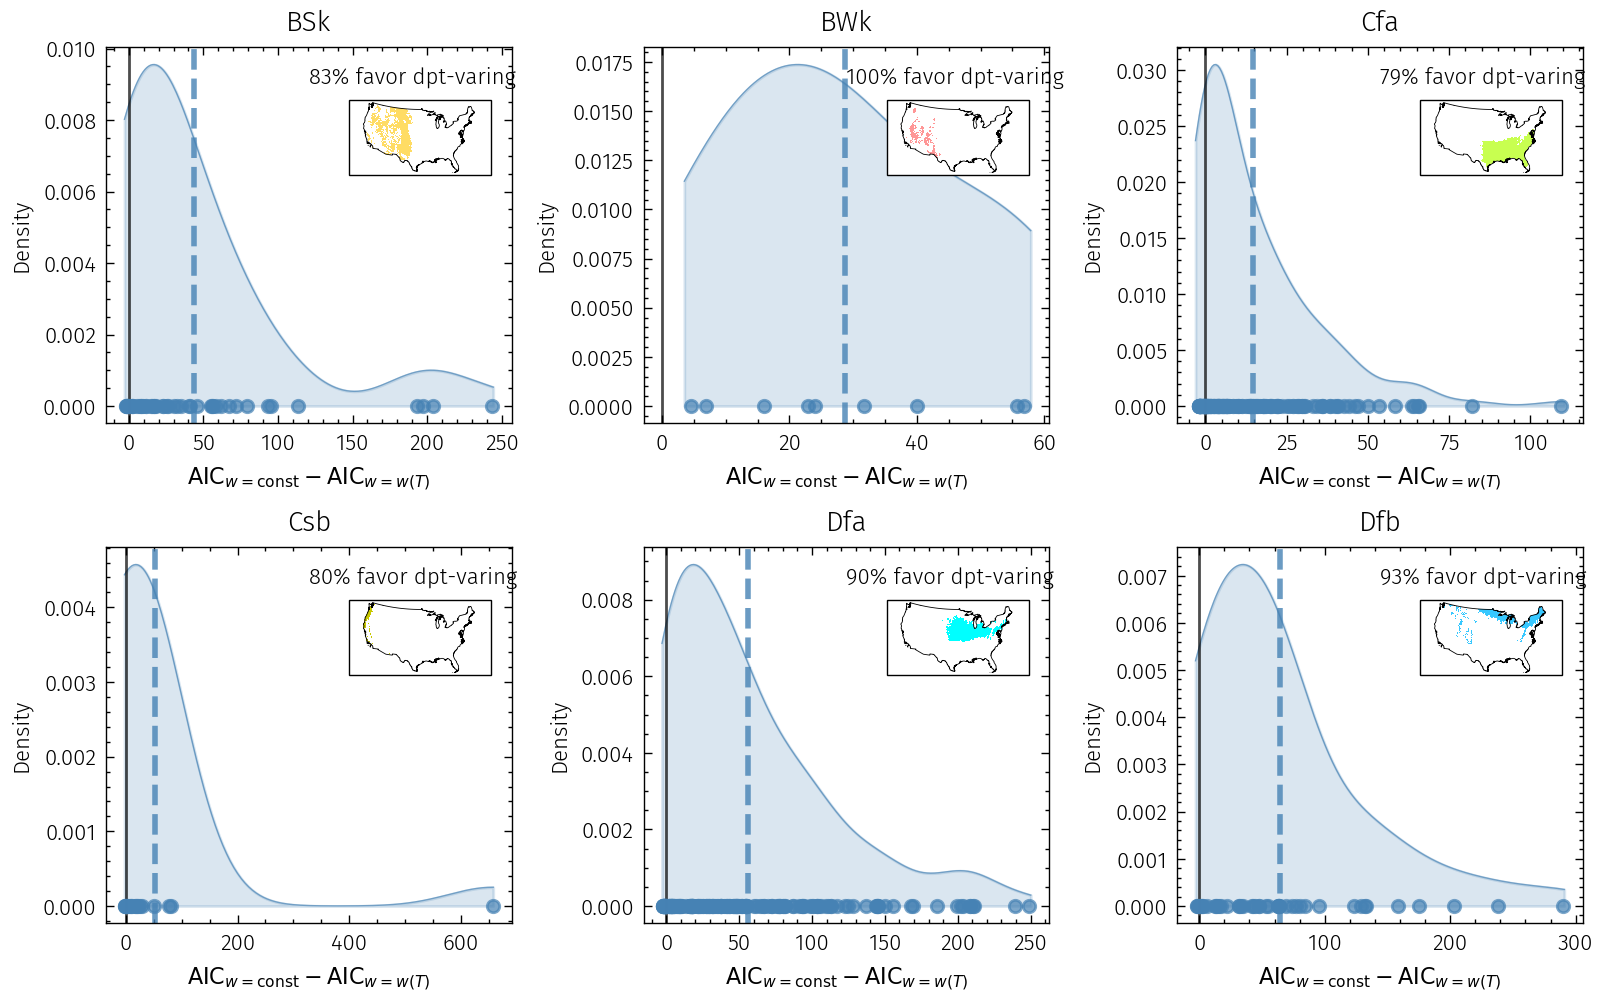

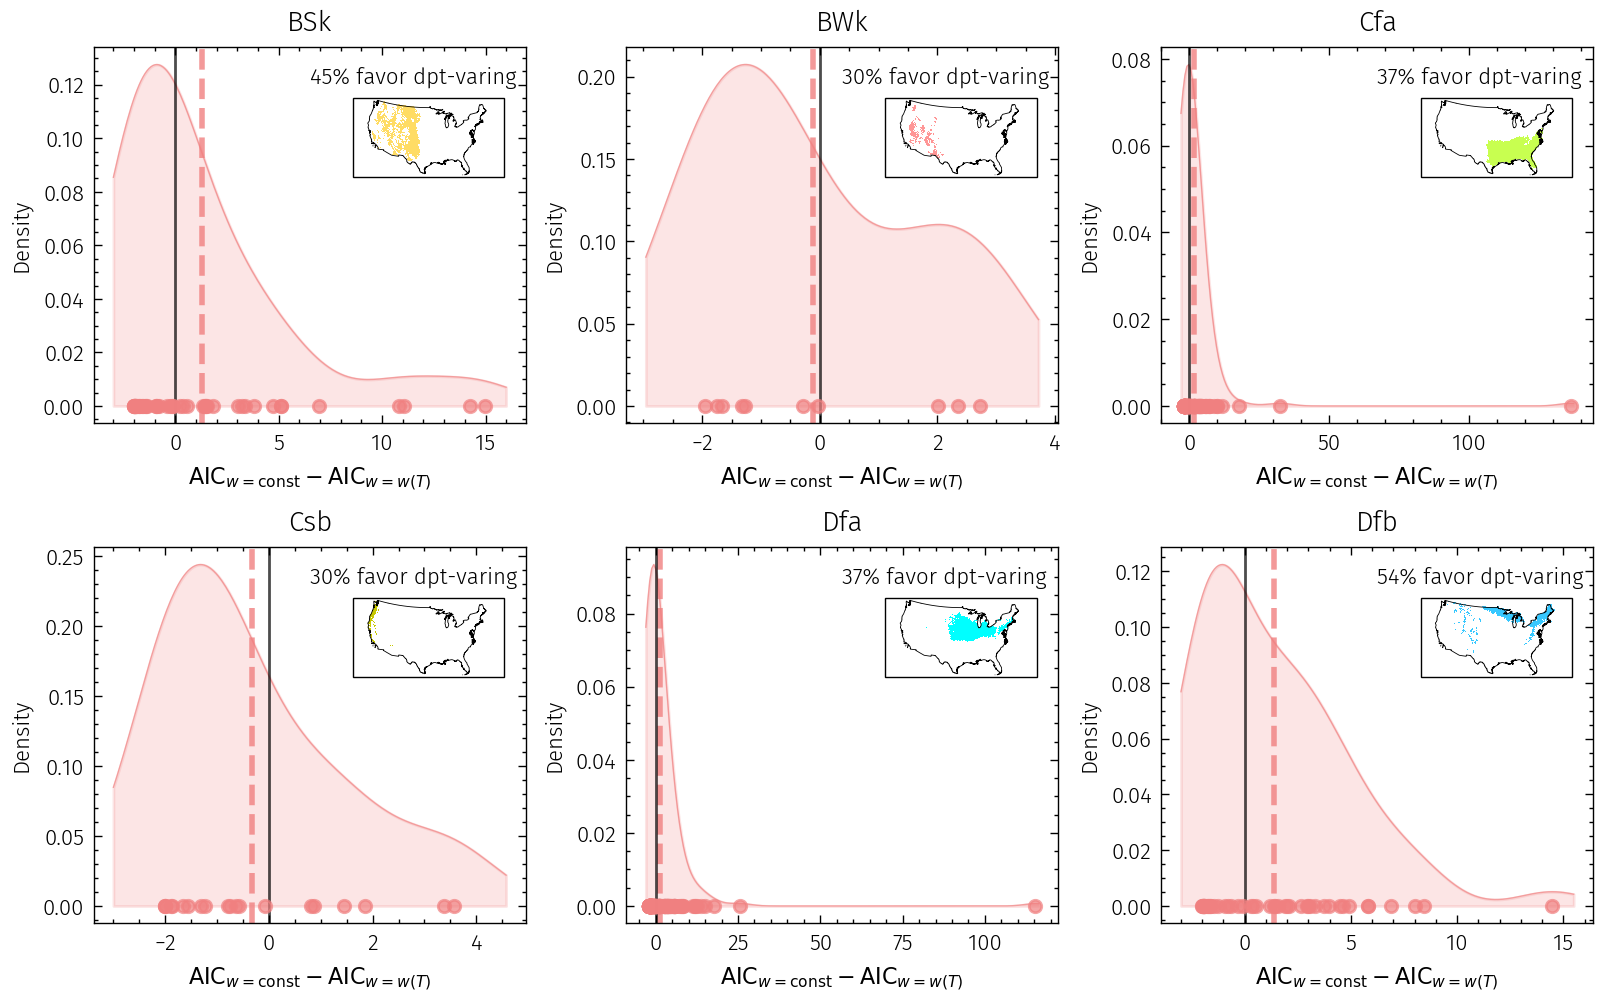

In [4]:
plot_aic_diff(aic_wt, aic_w_const, savedir=OUTPUT_PATH)

# 24h

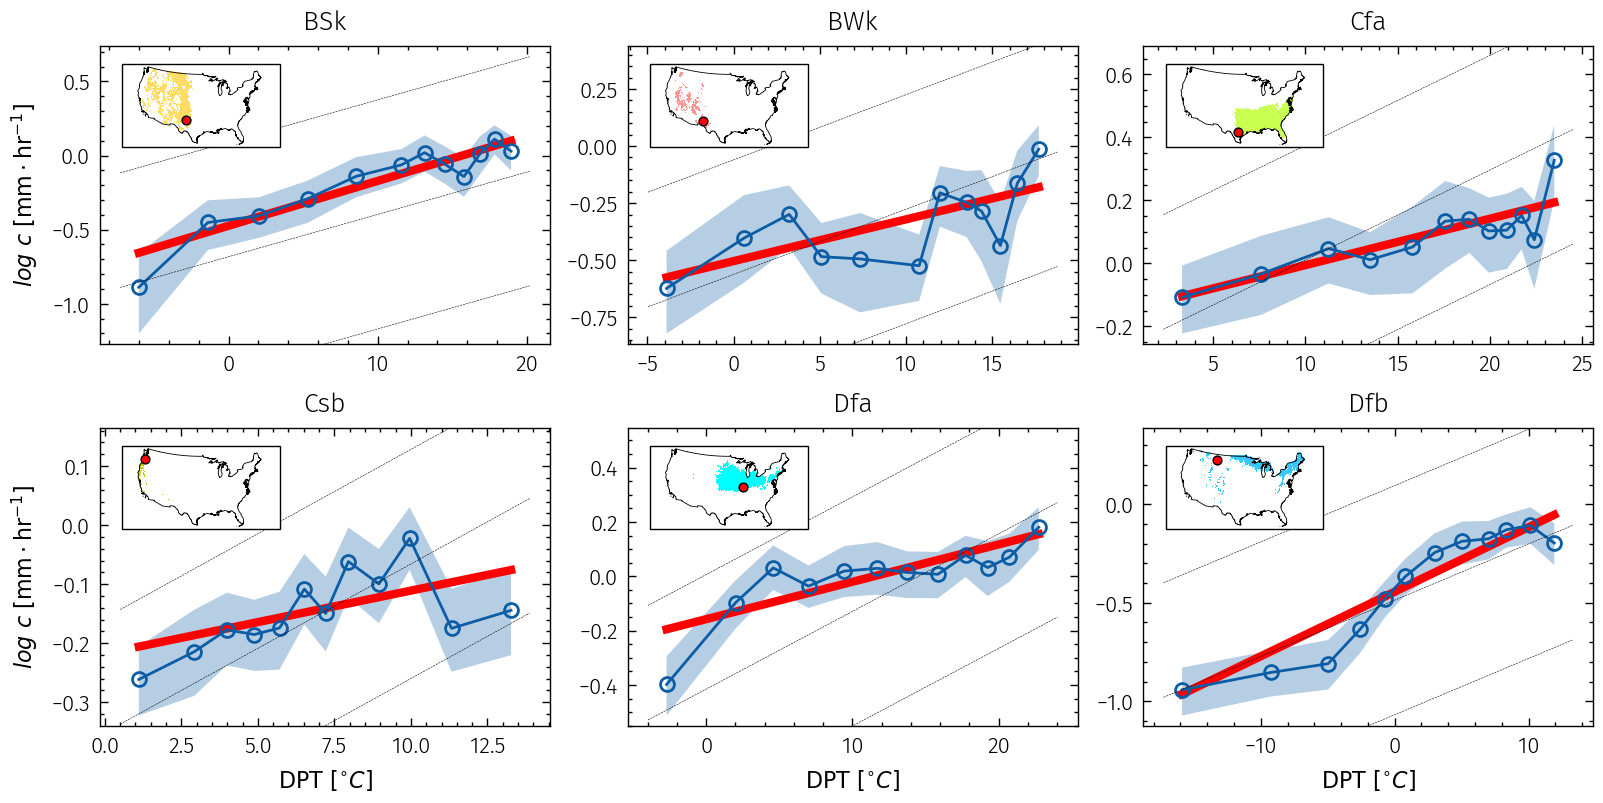

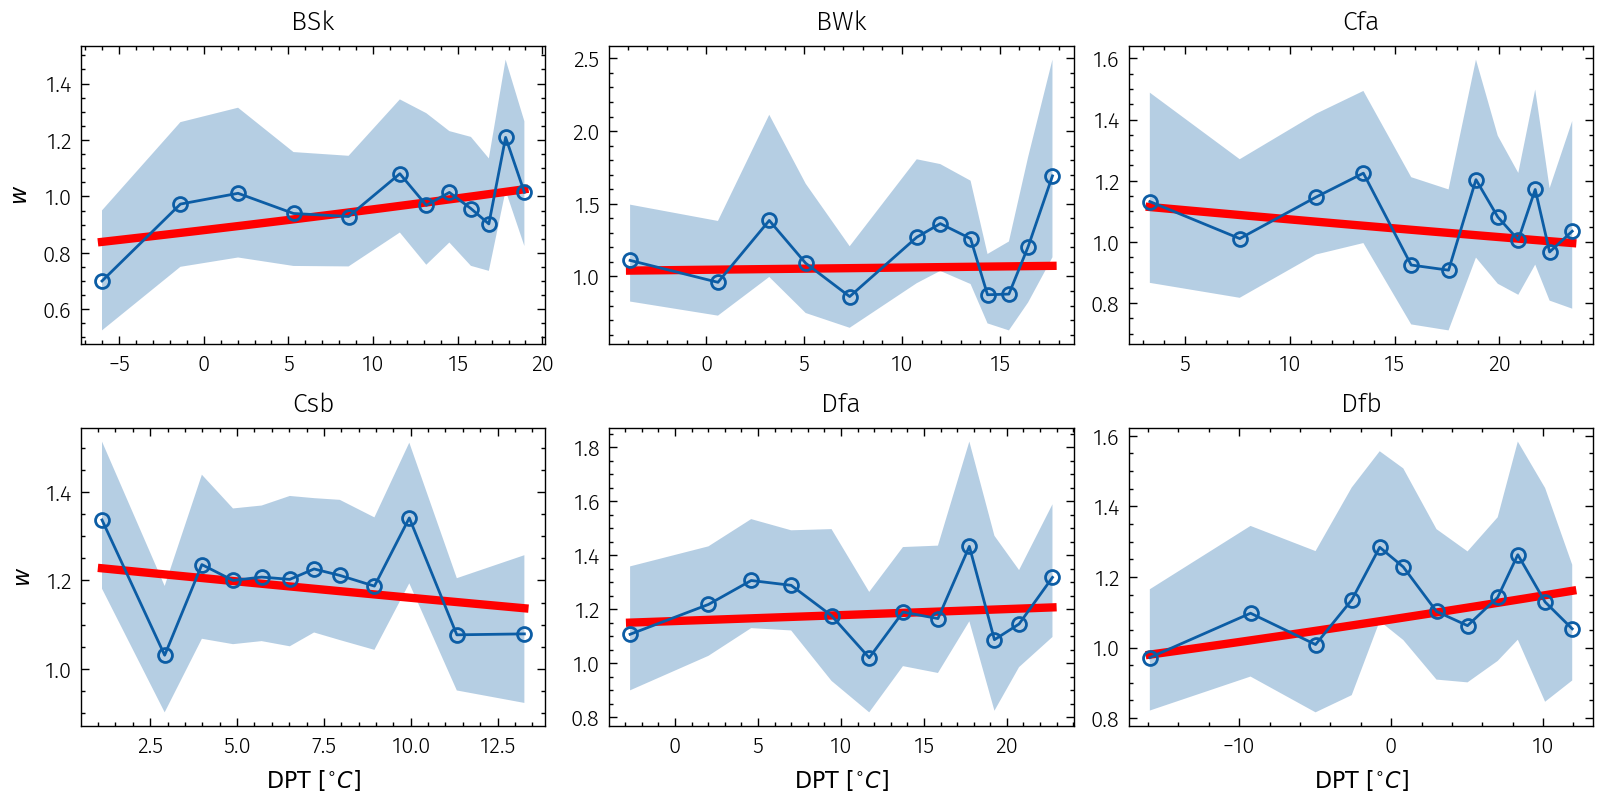

In [13]:
d = "24h"
cw_scaling_stations(d, VAR, savedir=OUTPUT_PATH)

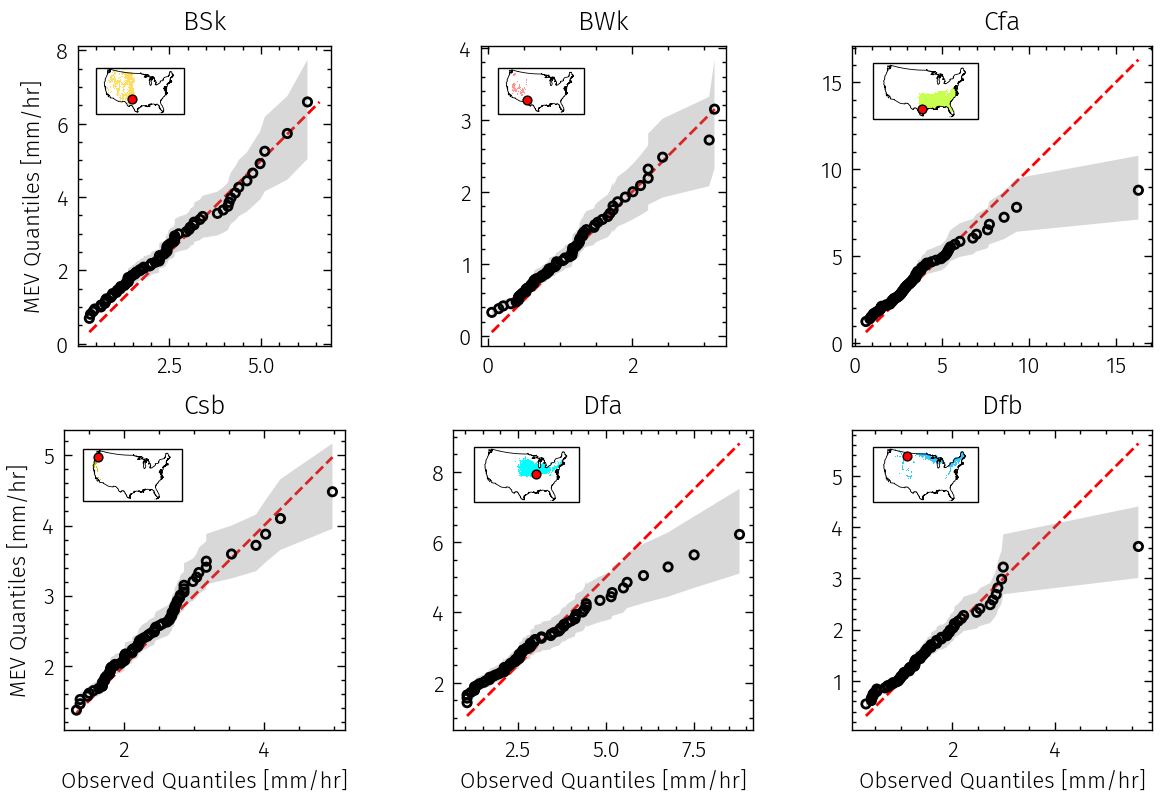

In [6]:
d = "24h"
qq_plots(d, VAR, savedir=OUTPUT_PATH)


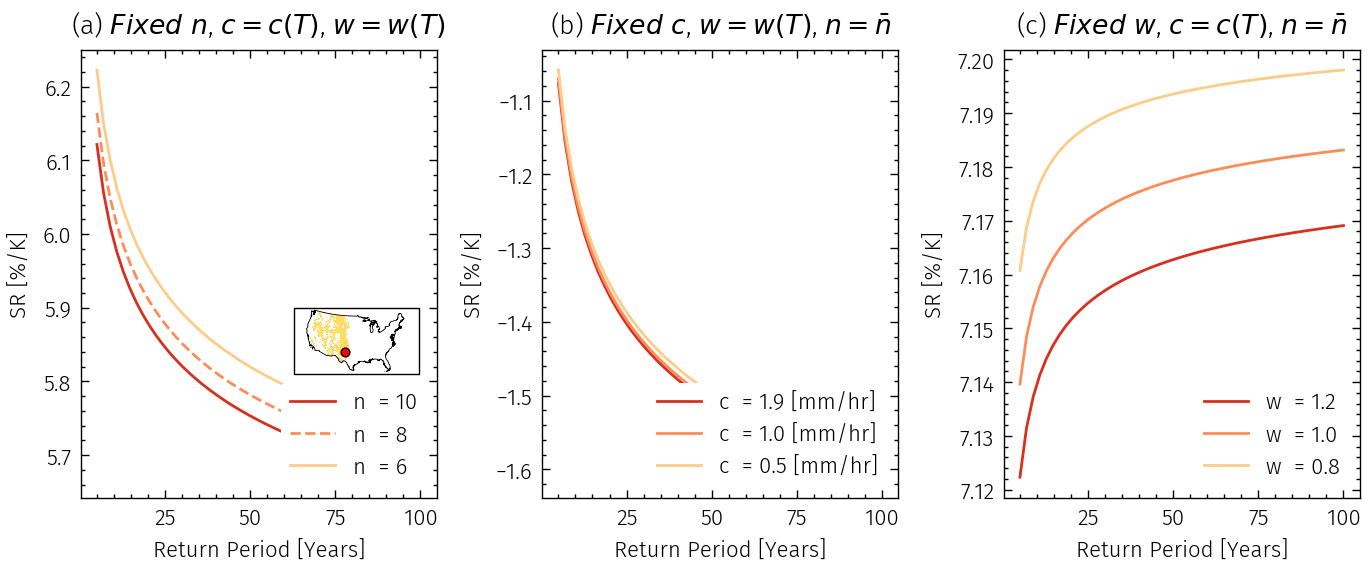

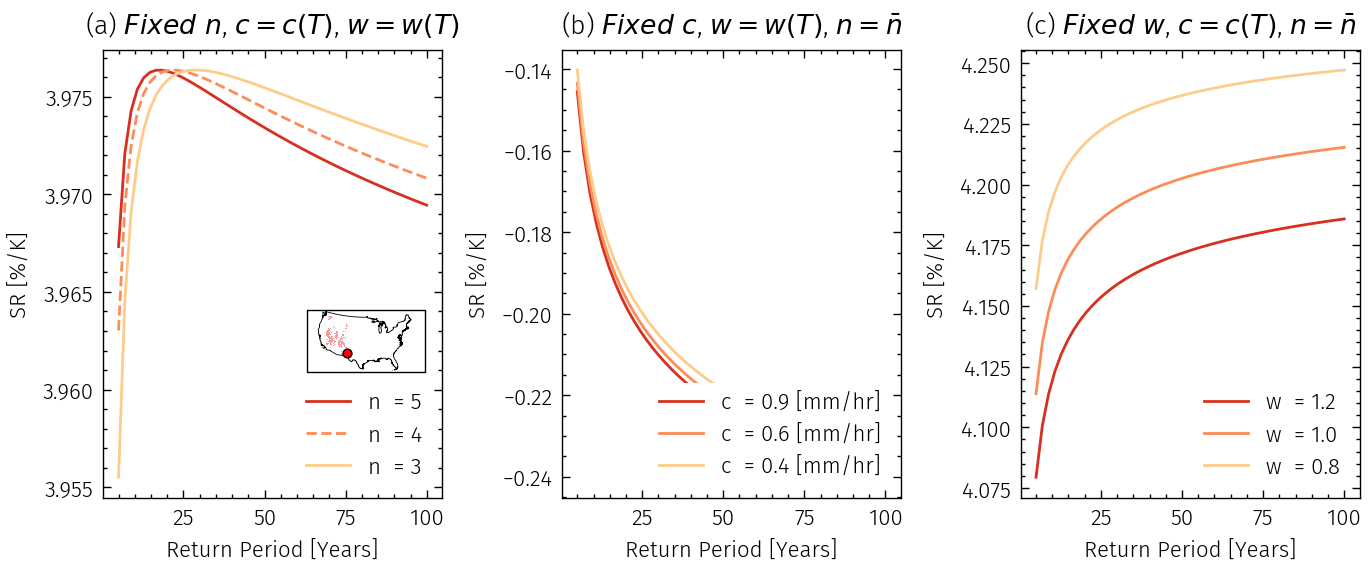

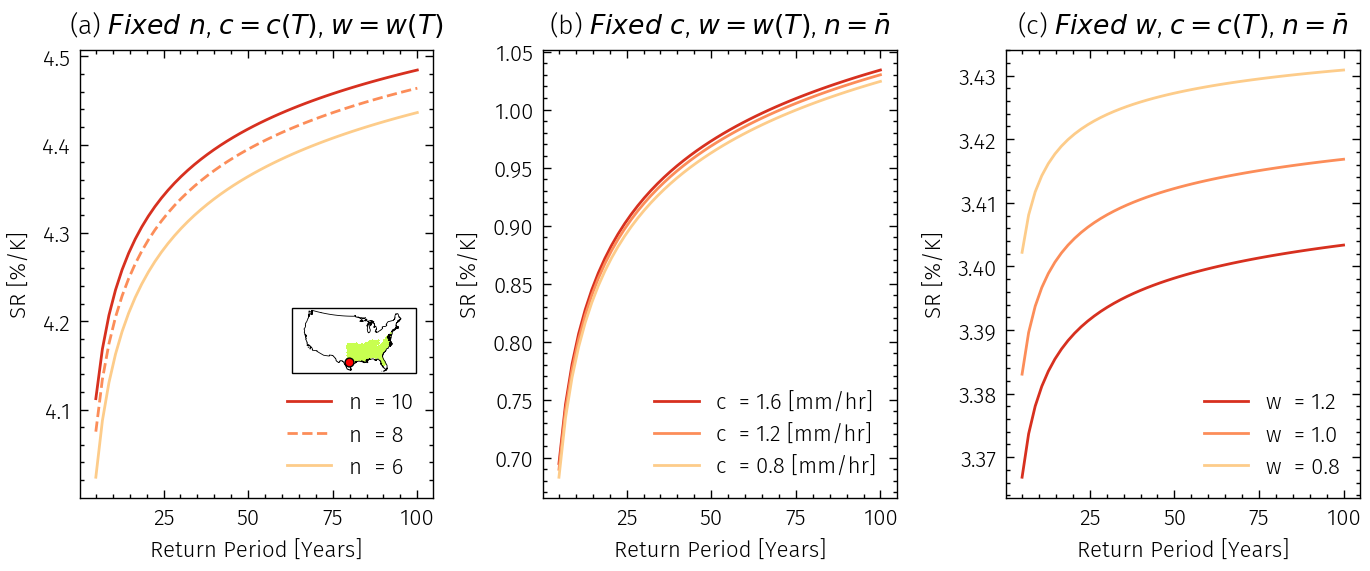

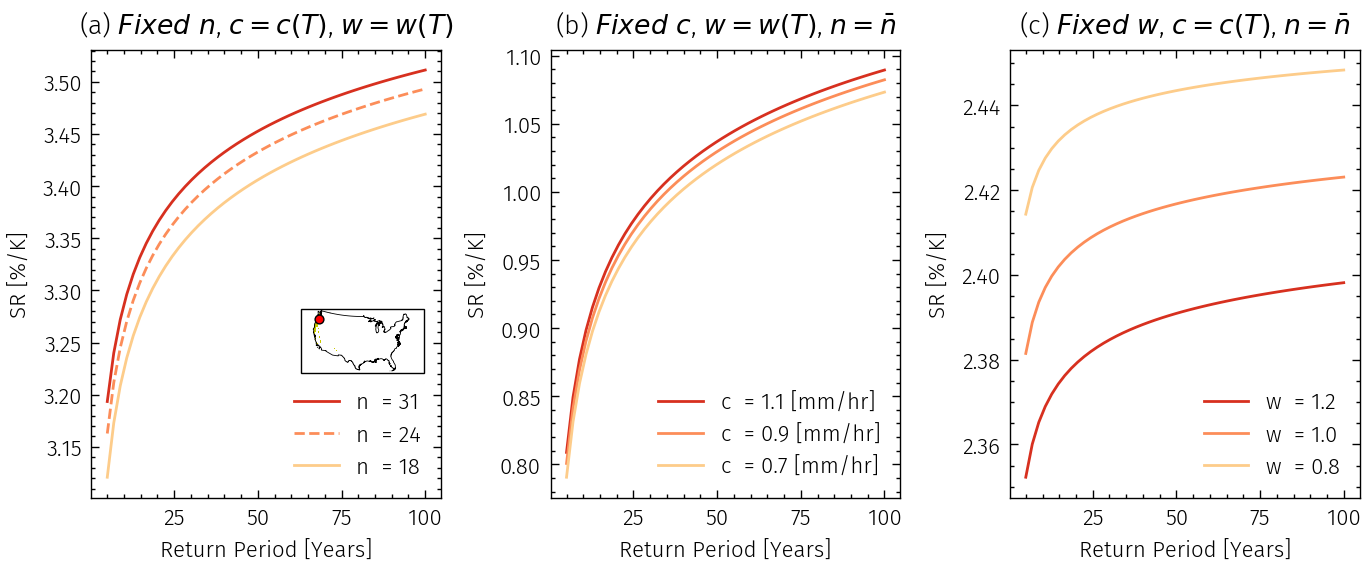

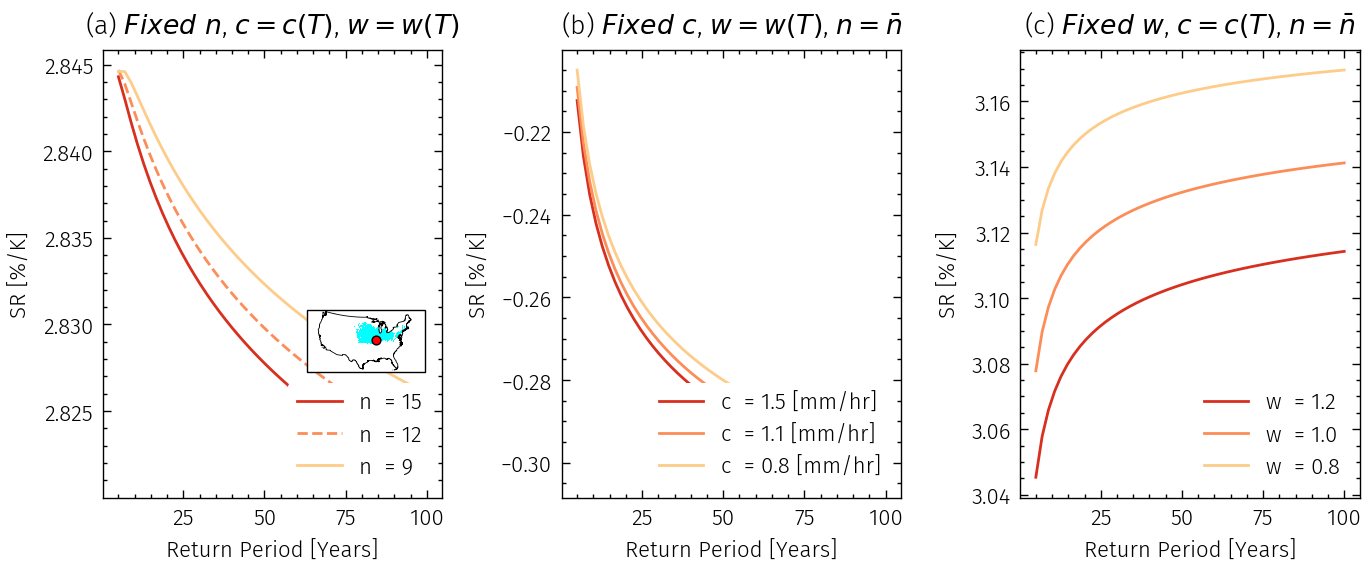

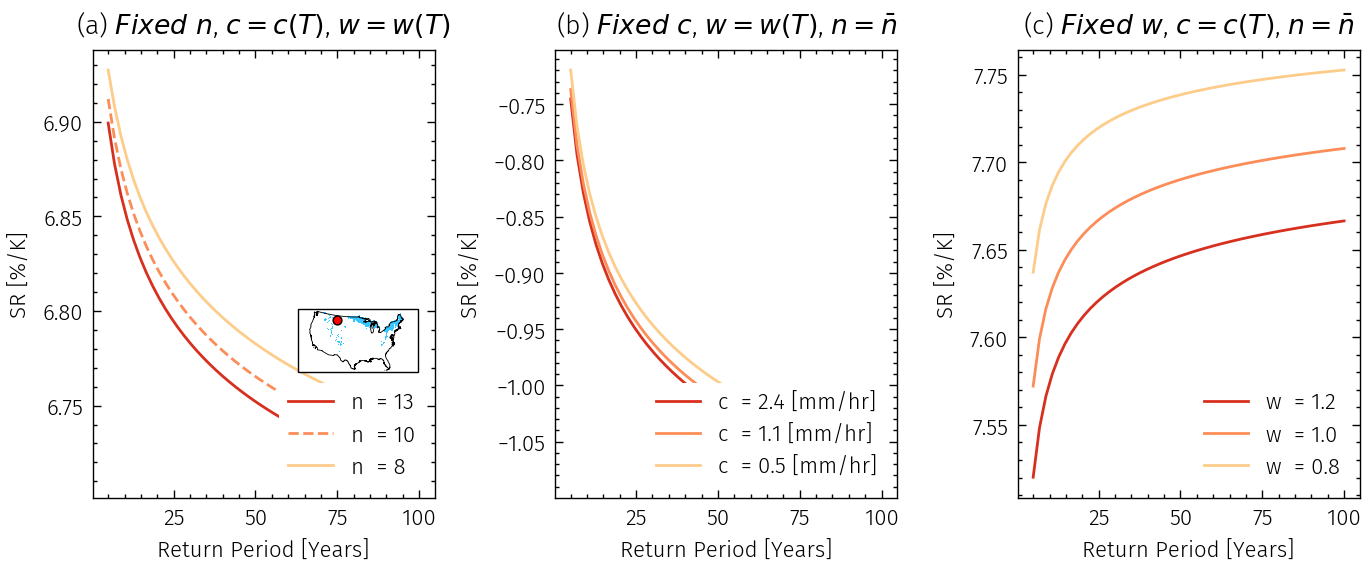

In [7]:
d = "24h"
SR_stations(d, VAR, savedir=OUTPUT_PATH)

# 1h

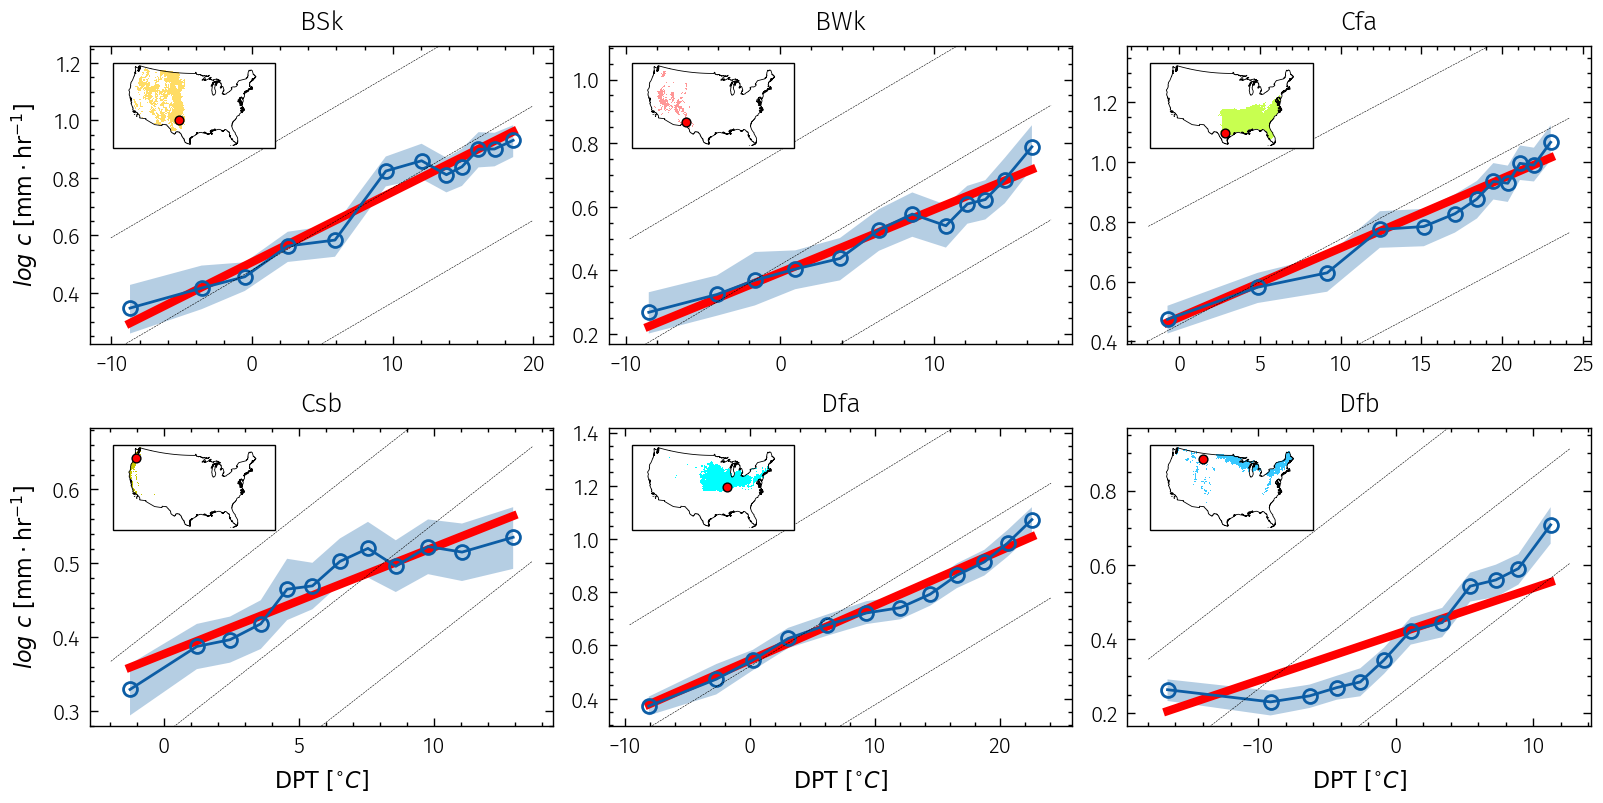

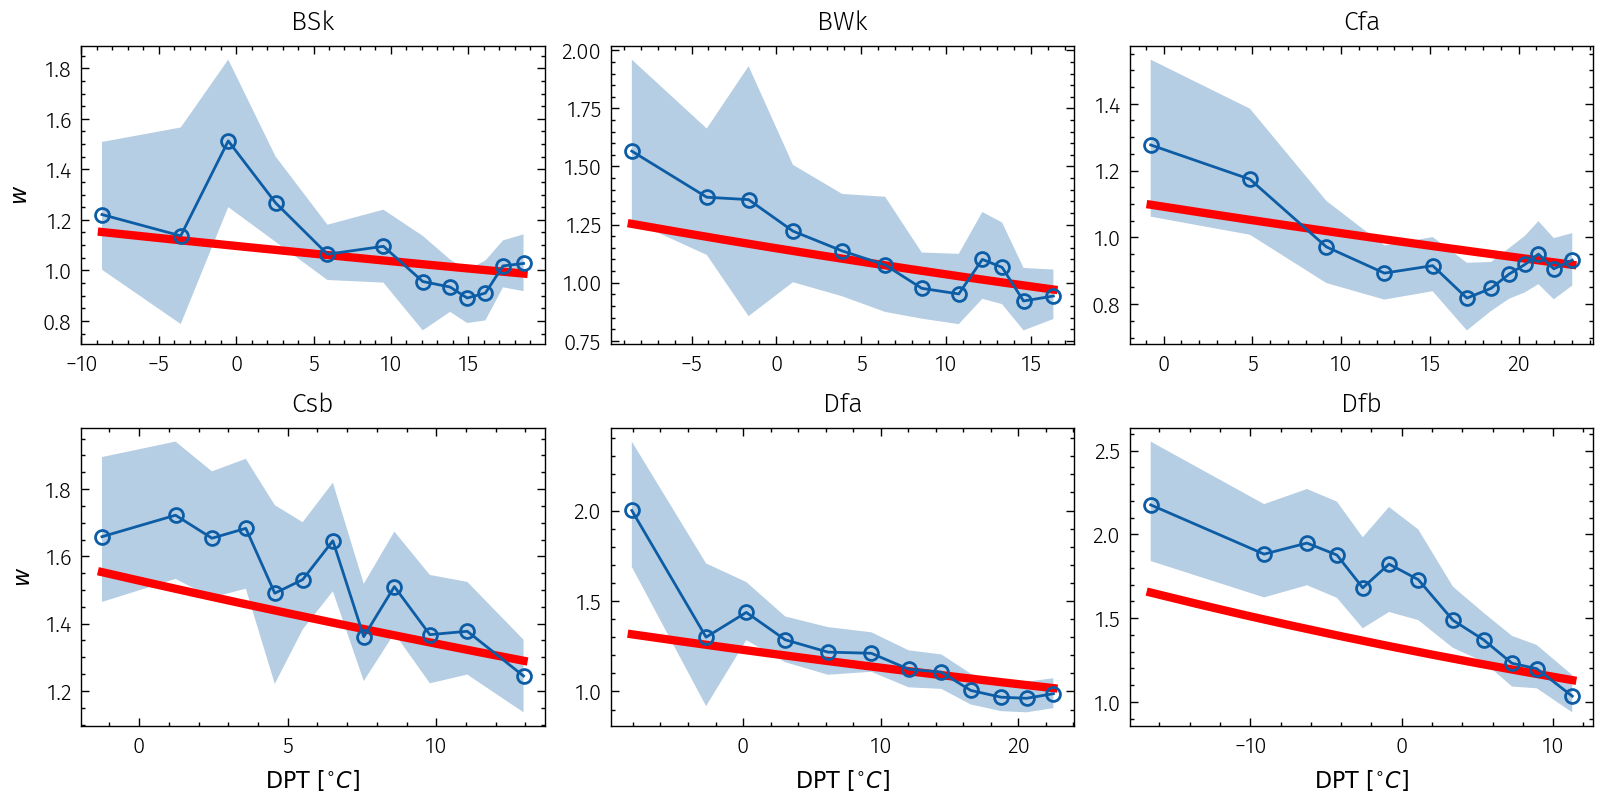

In [14]:
d = "1h"
cw_scaling_stations(d, VAR, savedir= OUTPUT_PATH)

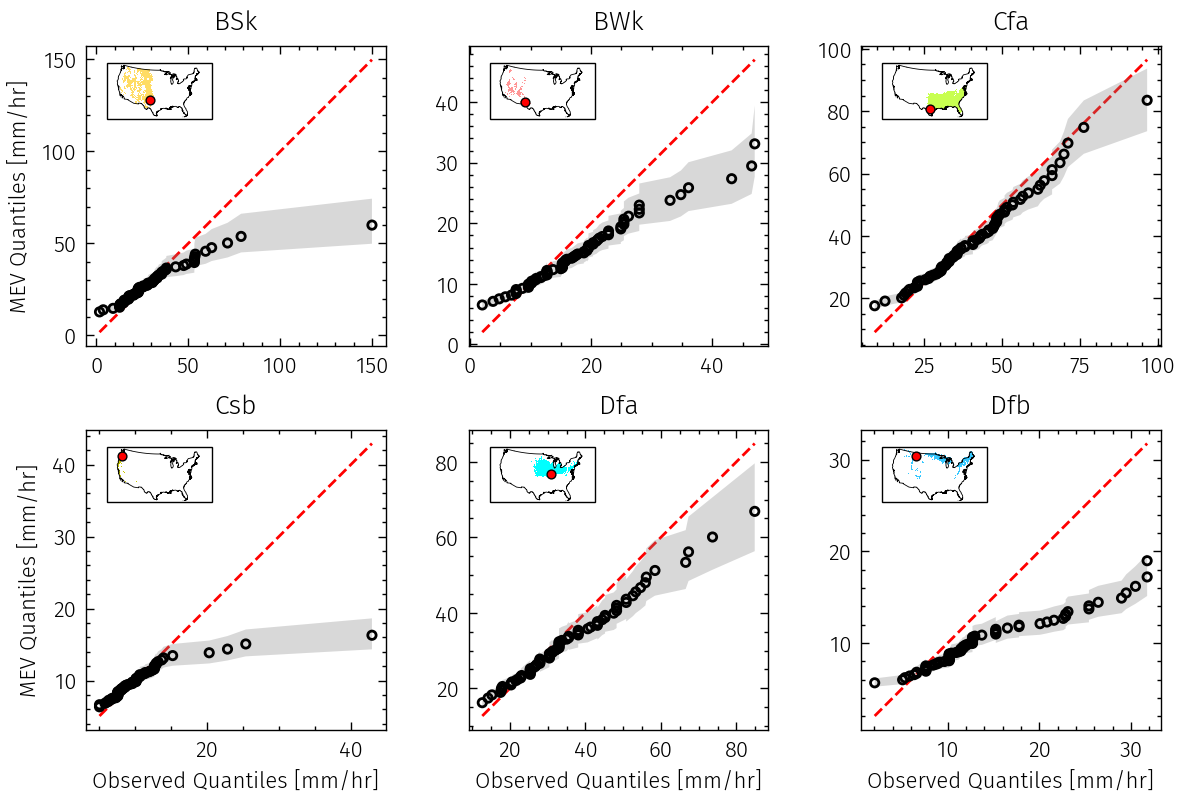

In [9]:
d = "1h"
qq_plots(d, VAR, savedir=OUTPUT_PATH)


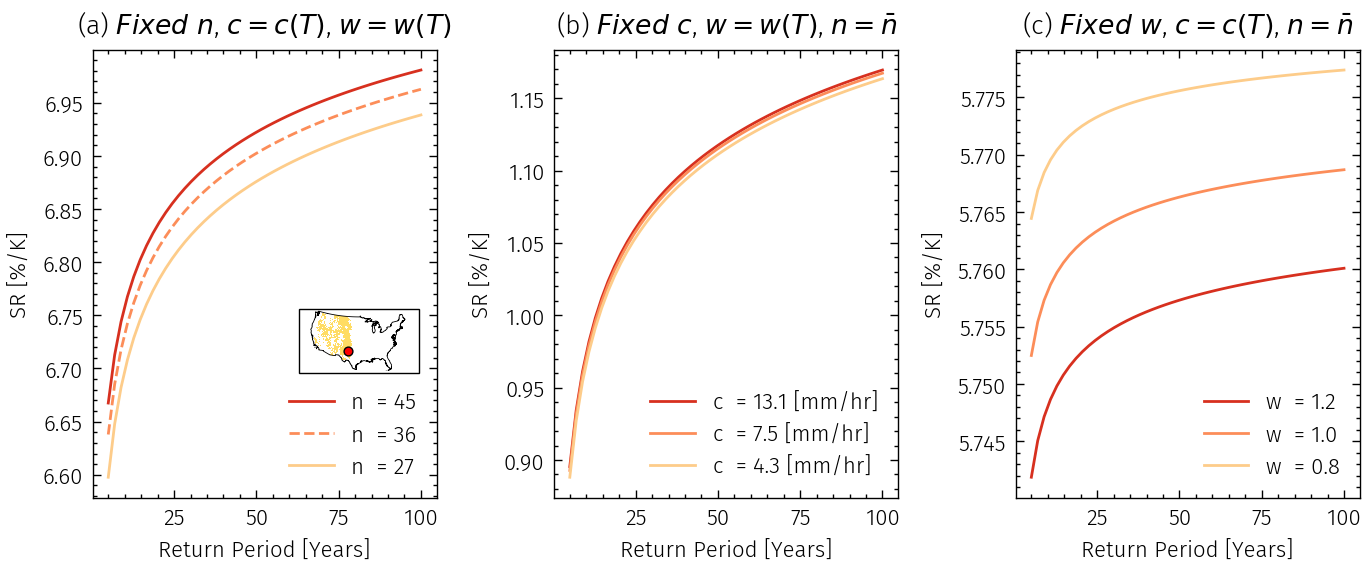

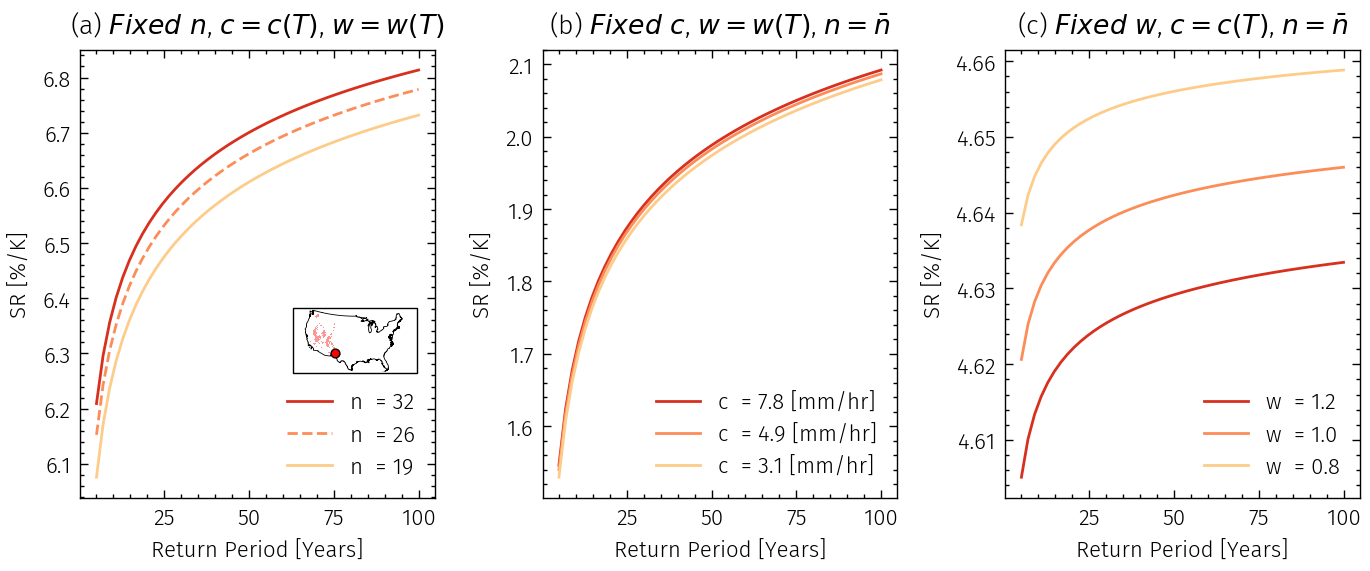

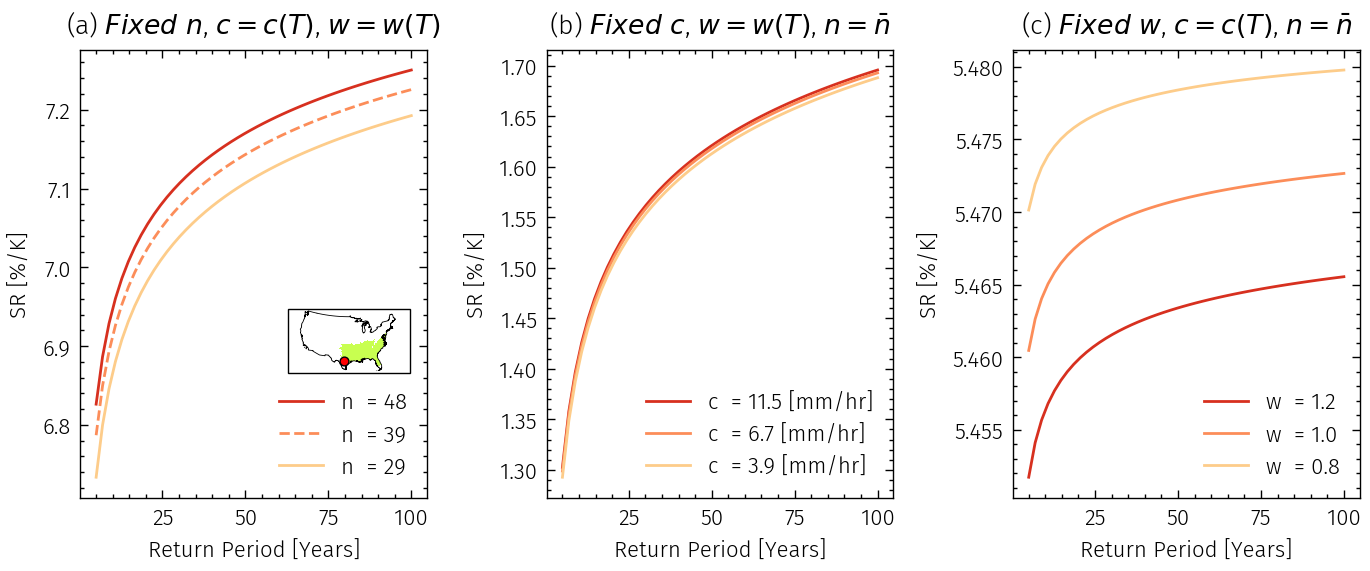

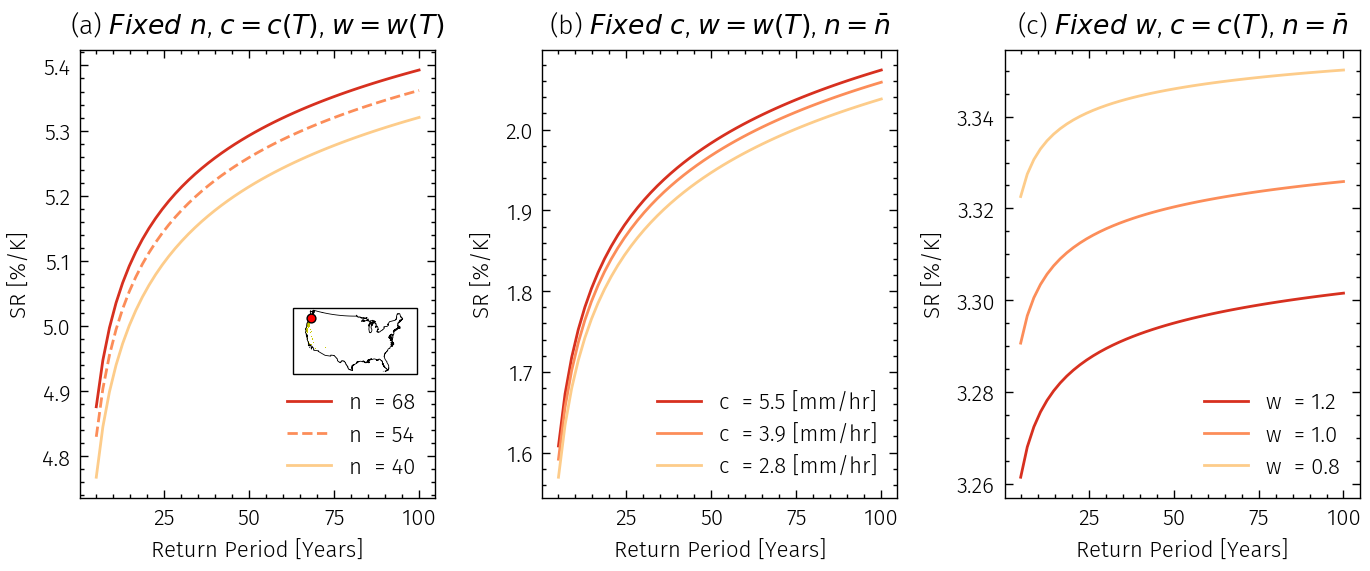

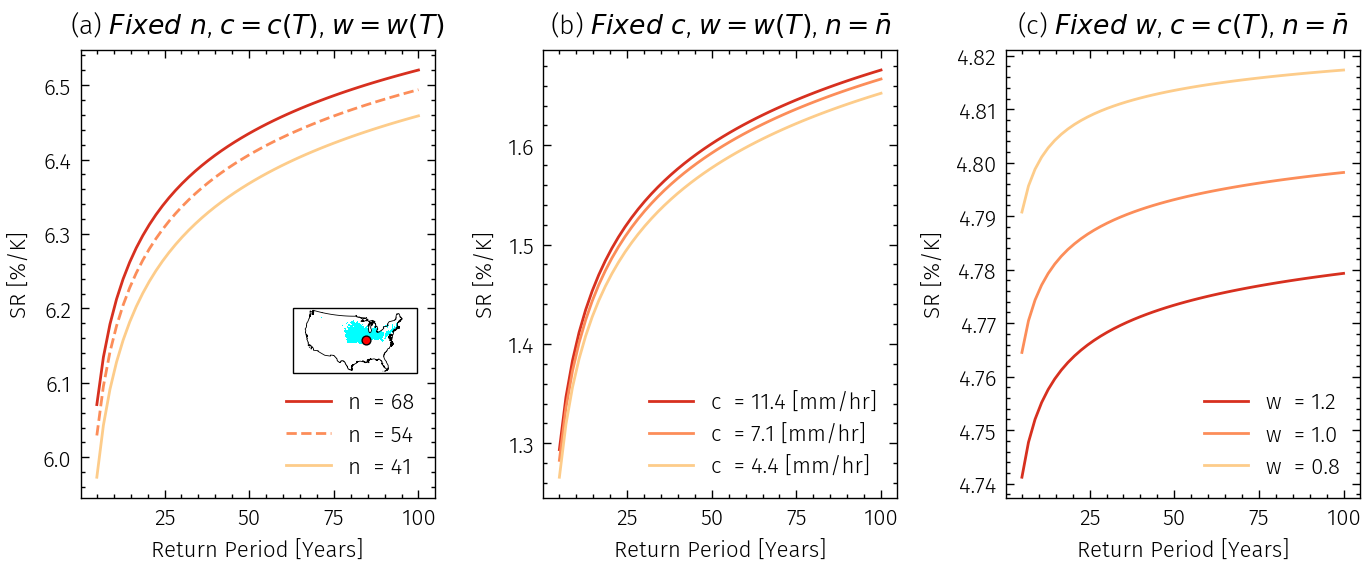

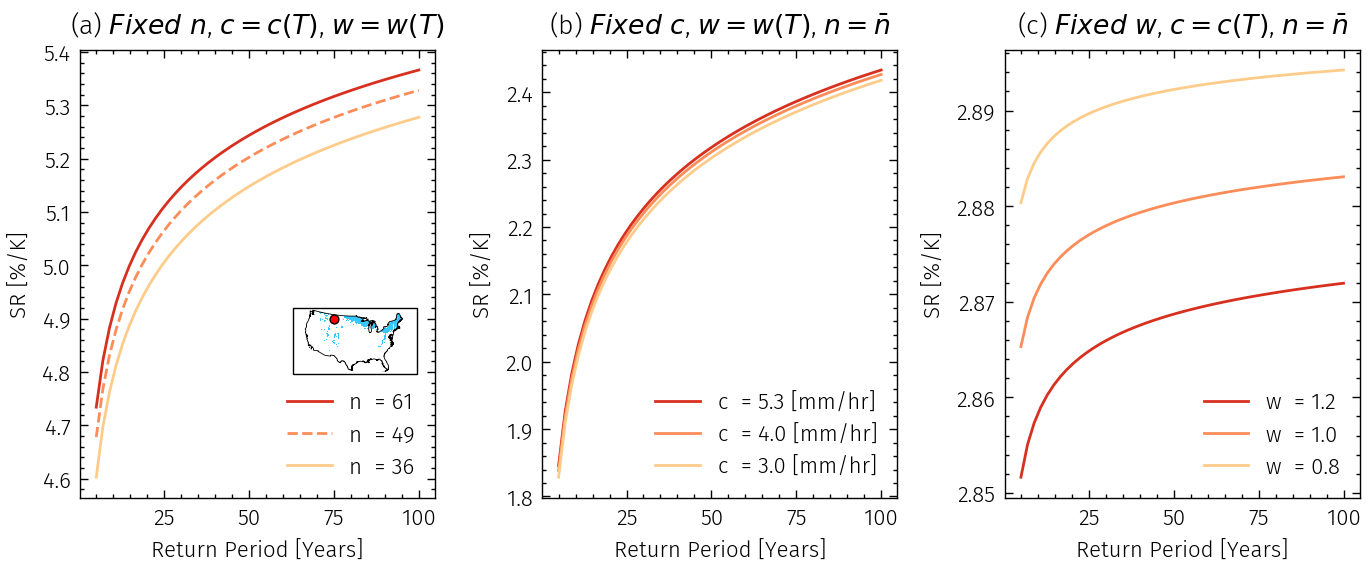

In [10]:
d = "1h"
SR_stations(d, VAR, savedir=OUTPUT_PATH)